In [32]:
skip_training = True

In [33]:
import time
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import tools
import tests

In [34]:
# When running on your own computer, you can specify the data directory by:
# data_dir = tools.select_data_dir('/your/local/data/directory')
data_dir = tools.select_data_dir()

The data directory is /coursedata


In [35]:
# Select the device for training (use GPU if you have one)
#device = torch.device('cuda:0')
device = torch.device('cpu')

In [36]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device("cpu")

# Data

The dataset is a set of sudoku puzzles with solutions obtained from [here](https://github.com/locuslab/SATNet).

In [37]:
import data
trainset = data.Sudoku(data_dir, train=True)
testset = data.Sudoku(data_dir, train=False)

x, y = trainset[0]
print(x.shape, y.shape)

torch.Size([81, 9]) torch.Size([81])


We can visualize the data in the following way.

In [38]:
def sudoku_to_labels(x):
    """Convert one-hot coded sudoku puzzles to labels. -1 corresponds to missing labels.
    
    Args:
      x of shape (n_rows=9, n_colums=9, n_digits=9): Tensor with a sudoku board. The digits are one-hot coded.
                  Cells with unknown digits have all zeros along the third dimension.
    """
    assert x.shape == torch.Size([9, 9, 9]), "Wrong shape {}".format(x.shape)
    is_filled = x.sum(dim=2)
    y = x.argmax(dim=2)
    y[~is_filled.bool()] = -1
    return y

In [39]:
print(sudoku_to_labels(x.view(9, 9, 9)))

tensor([[ 5,  6, -1, -1, -1, -1, -1, -1,  4],
        [-1, -1,  2, -1,  3, -1, -1,  7,  1],
        [-1,  3, -1, -1, -1,  4,  0,  2,  5],
        [-1, -1, -1,  6,  2, -1, -1,  8, -1],
        [ 2, -1,  3,  1, -1,  5, -1,  6, -1],
        [-1, -1,  0, -1,  8, -1,  5, -1, -1],
        [ 4, -1,  8, -1, -1,  7, -1, -1, -1],
        [-1, -1, -1,  8,  4, -1,  1, -1,  7],
        [-1, -1, -1,  0,  1,  6,  3, -1, -1]])


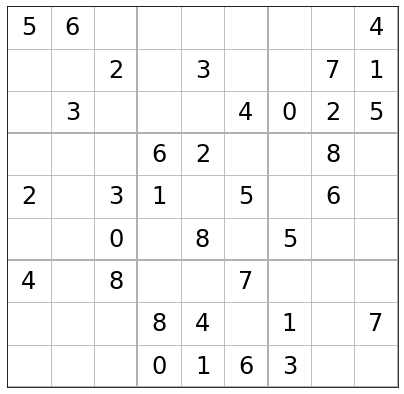

In [40]:
tools.draw_sudoku(x.view(9, 9, 9), logits=False)

## Graph

We describe each sudoku puzzle as a graph in which each node corresponds to one of the 9*9=81 cells in the puzzle. Each node is connected to 8+8+8-4=20 other nodes:
* 8 nodes that correspond to other cells in the same row
* 8 nodes that correspond to other cells in the same column
* 8 nodes that correspond to other cells in the same $3\times 3$ box
* 4 cells appear both in a $3\times 3$ box and in the same row or column.

In this exercise, we decribe a graph as a set of edges. Each edge is a pair (`src_id`, `dst_id`) where `src_id` is the id of the source node and `dst_id` is the id of the destination node. In the cell below, your task is to describe such a graph by producing two lists:
* a list of source node ids `src_id` of all edges
* a list of destination node ids `dst_id` of all edges

Note: Our tests assume that node ids are between 0 and 80. Please follow this convention.

In [41]:
def sudoku_edges():
    src = []
    dst = []
    for t in range(81):
        for f in range(20):
            src.append(t)
        current = []
        for r in range(9):
            n1 = (t-(t%9))+r
            n2 = (t%9)+9*r
            if n1!=t and n1 not in current:
                current.append(n1)
            if n2!=t and n2 not in current:
                current.append(n2)
            n3 = (((t-(t%9))/9-(((t-(t%9))/9)%3))*9+(t-(t%3))%9) + r%3 + (r-(r%3))*3
            if n3!=t and n3 not in current:
                current.append(n3)
        dst += current
    return torch.LongTensor(src), torch.LongTensor(dst)


In [42]:
sudoku_src_ids, sudoku_dst_ids = sudoku_edges()
print('Number of edges in each sudoku graph: %d' % len(sudoku_src_ids))
assert sudoku_src_ids.dtype == torch.long and sudoku_dst_ids.dtype == torch.long
assert len(sudoku_src_ids) == len(sudoku_dst_ids), "The number of source and destination nodes should be same."
assert len(sudoku_src_ids) == 1620, "Wrong number of edges ({}), expected: 1620".format(len(sudoku_src_ids))
assert min(sudoku_src_ids) == 0 and max(sudoku_src_ids) == 80, "Node ids should be between 0 and 80"
assert min(sudoku_dst_ids) == 0 and max(sudoku_dst_ids) == 80, "Node ids should be between 0 and 80"

Number of edges in each sudoku graph: 1620


## Custom data loader

We first create a custom data loader to process a mini-batch of graphs (in parallel) to compute the derivatives wrt the parameters of the graph neural network. To do that, **we transform a mini-batch of graphs to one large graph without interconnecting edges between the subgraphs corresponding to individual examples in the mini-batch.** We do this using a custom collate function that you need to implement in the cell below.

In [43]:
def collate(list_of_samples):
    inputs = []
    targets = []
    for t in list_of_samples:
        inputs.append(t[0])
        targets.append(t[1])
    inputs = torch.cat(inputs)
    targets = torch.cat(targets)
    src = []
    dst = []
    for u in range(len(list_of_samples)):
        s,d = sudoku_edges()
        src.append(s+(81*u))
        dst.append(d+(81*u))
    return inputs, targets, torch.cat(src), torch.cat(dst)


In [44]:
def test_collate_shapes():
    batch_size = 2
    n_nodes = 81
    inputs, targets, src_ids, dst_ids = collate([trainset[0], trainset[1]])
    assert inputs.shape == torch.Size([batch_size*n_nodes, 9]), f"Bad inputs.shape: {inputs.shape}"
    assert targets.shape == torch.Size([batch_size*n_nodes]), f"Bad targets.shape: {targets.shape}"
    assert src_ids.shape == torch.Size([batch_size*1620]), f"Bad src_ids.shape: {src_ids.shape}"
    assert dst_ids.shape == torch.Size([batch_size*1620]), f"Bad dst_ids.shape: {dst_ids.shape}"
    assert min(src_ids) == 0 and max(src_ids) == batch_size*81-1
    assert min(dst_ids) == 0 and max(dst_ids) == batch_size*81-1
    print('Success')

test_collate_shapes()

Success


In [45]:
trainloader = DataLoader(trainset, batch_size=16, collate_fn=collate)
testloader = DataLoader(testset, batch_size=16, collate_fn=collate)

<img src="recurrent_rn.png" width=300 style="float: right;">

# Graph neural network

You need to implement a graph neural network in the cell below. Its forward function consists of `n_iters` iterations with the following steps:
* For each node, compute the messages from all its neighbors using the message network (see description below).
* For each destination node, aggregate (by summation) all the messages sent by its neighbors. You may find it useful to use function [`index_add_`](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.index_add_) for that.
* The aggregated messages are concatenated with the node inputs to form the inputs of the gated recurrent units (GRUs) whose states represent the states of the nodes. The node inputs are one-hot coded digits 1-9 of the sudoku puzzle, a missing digit is encoded with all zeros. 
* The states of the GRUs are updated using the standard GRU computations.
* The states of each graph node are linearly combined to compute the output of the corresponding node at the current iteration.

**Note that since we combine all graphs in the mini-batch into a single graph using `collate()` function, we do not need to care about batches in our implementation of GNN.**


### Message network

* All messages are computed with the same message network (shared parameters).
* The message network takes as inputs the states of the source node and the states of the destination node and produces a vector with `n_edge_features`.
* We used as the message network a multilayer perceptron (MLP) network with the following architecture:
  * hidden layer with 96 neurons and ReLU nonlinearity
  * hidden layer with 96 neurons and ReLU nonlinearity
  * output layer with `n_edge_features` output features.
* **Important:** Our tests assume that the message network is defined as an attribute called `msg_net`, that is it can be accessed as follows:
```
gnn = GNN()
print(gnn.msg_net)
```

### Notes

* Please initialize the node states (before the first iteration) with all zeros.
* The messages computed in the first iteration are not informative because they combine zero states.

In [46]:
class GNN(nn.Module):
    def __init__(self, n_iters=7, n_node_features=10, n_node_inputs=9, n_edge_features=11, n_node_outputs=9):
        super(GNN, self).__init__()
        self.n_iters = n_iters
        self.n_node_features = n_node_features
        self.n_node_inputs = n_node_inputs
        self.n_edge_features = n_edge_features
        self.n_node_outputs = n_node_outputs
        self.msg_net = nn.Sequential(nn.Linear(n_node_features*2,96),(nn.ReLU()),(nn.Linear(96,96)),(nn.ReLU()),(nn.Linear(96,n_edge_features)))
        self.gru = nn.GRU(n_edge_features+n_node_inputs,n_node_features)
        self.l = nn.Linear(n_node_features, n_node_outputs)

    def forward(self, node_inputs, src_ids, dst_ids):
        nodeStates = torch.zeros(len(node_inputs),self.n_node_features)
        out = []
        for rep in range(self.n_iters):
            '''messages = []
            for f in range(len(dst_ids)):
                x = torch.cat([nodeStates[dst_ids[f]],nodeStates[src_ids[f]]]).unsqueeze(0)
                x = self.msg_net(x)
                messages.append(x)
            messages = torch.stack(messages)'''
            messages = self.msg_net( torch.cat([nodeStates[dst_ids],nodeStates[src_ids]],dim=1))
            rec = torch.zeros(len(node_inputs),self.n_edge_features)
            rec.index_add_(0,dst_ids,messages)
            o,h = self.gru(torch.cat([rec,node_inputs],dim=1).unsqueeze(0),nodeStates.unsqueeze(0))
            nodeStates=h.squeeze(0)
            out.append(self.l(o.squeeze(0)))
        return torch.stack(out)

In [47]:
# Shape tests of the message network
def test_GNN_msg_net():
    src_ids, dst_ids = sudoku_edges()
    src_ids, dst_ids = torch.LongTensor(src_ids), torch.LongTensor(dst_ids)
    n_nodes = 81
    n_edges = len(src_ids)
    n_node_features = 5
    n_edge_features = 6

    gnn = GNN(n_iters=7, n_node_features=n_node_features, n_edge_features=n_edge_features)
    msg_net_inputs = torch.zeros(n_edges, 2*n_node_features)
    assert hasattr(gnn, 'msg_net'), "Cannot find the message network."
    messages = gnn.msg_net(msg_net_inputs)  # [n_edges, n_edge_features]
    assert messages.shape == torch.Size([n_edges, n_edge_features]), f"Bad messages.shape: {messages.shape}"
    print('Success')

test_GNN_msg_net()

Success


In [48]:
# Shape tests
def test_GNN_shape():
    src_ids, dst_ids = sudoku_edges()
    src_ids, dst_ids = torch.LongTensor(src_ids), torch.LongTensor(dst_ids)
    n_nodes = 81

    gnn = GNN(n_iters=7)
    node_inputs = torch.zeros([n_nodes, 9])
    outputs = gnn(node_inputs, src_ids, dst_ids)  # [n_iters, batch*n_nodes, 9]
    assert outputs.shape == torch.Size([gnn.n_iters, n_nodes, 9]), f"Bad outputs.shape: {outputs.shape}"
    print('Success')

test_GNN_shape()

Success


In [49]:
# Test of the forward function
tests.test_GNN_forward(GNN)

outputs:
 tensor([[[ 0.0000,  0.0498],
         [ 0.0000,  0.2311],
         [ 0.0000,  0.3581]],

        [[-0.0012,  0.0736],
         [-0.0058,  0.3434],
         [-0.0089,  0.5360]]])
expected:
 tensor([[[ 0.0000,  0.0498],
         [ 0.0000,  0.2311],
         [ 0.0000,  0.3581]],

        [[-0.0012,  0.0736],
         [-0.0058,  0.3434],
         [-0.0089,  0.5360]]])
Success


## Train the network

### Training loop

Your task is to implement the training loop. The recommended hyperparameters:
* Adam optimizer with learning rate 0.001
* 30 epochs is usually enough for training to converge.
* The loss should be the mean of the classification losses computed at **every** GNN iteration. This way you encourage the GNN to find the correct solution with as few iterations as possible.

Hints:
* The training loss at convergence can reach 0.25. The classification loss computed after the **last** GNN iteration should be close to 0.
* The fraction of solved test puzzles is usually close to 1 (we will use the threshold of 0.93 in the tests).
* We recommend you to track the fraction of solved puzzles in the test set using the function below.

In [50]:
# Create network
gnn = GNN()
gnn.to(device)

GNN(
  (msg_net): Sequential(
    (0): Linear(in_features=20, out_features=96, bias=True)
    (1): ReLU()
    (2): Linear(in_features=96, out_features=96, bias=True)
    (3): ReLU()
    (4): Linear(in_features=96, out_features=11, bias=True)
  )
  (gru): GRU(20, 10)
  (l): Linear(in_features=10, out_features=9, bias=True)
)

In [51]:
def fraction_of_solved_puzzles(gnn, testloader):
    with torch.no_grad():
        n_test = 0
        n_test_solved = 0
        for i, (inputs, targets, src_ids, dst_ids) in enumerate(testloader):
            # inputs is [n_nodes, 9*9, 9]
            # targets is [n_nodes]
            batch_size = inputs.size(0) // 81
            inputs, targets = inputs.to(device), targets.to(device)
            src_ids, dst_ids = src_ids.to(device), dst_ids.to(device)

            outputs = gnn(inputs, src_ids, dst_ids)  # [n_iters, batch*n_nodes, 9]
            solution = outputs.view(gnn.n_iters, batch_size, 9, 9, 9)

            final_solution = solution[-1].argmax(dim=3)
            solved = (final_solution.view(-1, 81) == targets.view(batch_size, 81)).all(dim=1)
            n_test += solved.size(0)
            n_test_solved += solved.sum().item()
            return n_test_solved / n_test

In [52]:
# Implement the training loop here
if not skip_training:
    epochs = 10
    lr = 0.001
    optimizer = optim.Adam(gnn.parameters(),lr)
    for t in range(epochs):
        gnn.train()
        for data,target,s,d in trainloader:
            data = data.to(device)
            target = target.to(device)
            s = s.to(device)
            d = d.to(device)
            optimizer.zero_grad()
            output = gnn(data,s,d)
            loss = nn.CrossEntropyLoss()
            losses = []
            for c in output:
                losses.append(loss(c, target))
            losses = torch.stack(losses)
            output2 = torch.mean(losses).unsqueeze(0)
            output2.backward()
            optimizer.step()
        print(fraction_of_solved_puzzles(gnn,testloader))

In [53]:
# Save the model to disk (the pth-files will be submitted automatically together with your notebook)
if not skip_training:
    tools.save_model(gnn, '7_gnn.pth')
else:
    gnn = GNN()
    tools.load_model(gnn, '7_gnn.pth', device)

Model loaded from 7_gnn.pth.


## Evaluate the trained model

In [54]:
# Get graph iterations for some test puzzles
with torch.no_grad():
    inputs, targets, src_ids, dst_ids = iter(testloader).next()
    inputs, targets = inputs.to(device), targets.to(device)
    src_ids, dst_ids = src_ids.to(device), dst_ids.to(device)

    batch_size = inputs.size(0) // 81
    outputs = gnn(inputs, src_ids, dst_ids)  # [n_iters, n_nodes, 9]

    solution = outputs.view(gnn.n_iters, batch_size, 9, 9, 9)
    final_solution = solution[-1].argmax(dim=3)
    print('Solved puzzles in the current mini-batch:')
    print((final_solution.view(-1, 81) == targets.view(batch_size, 81)).all(dim=1))

Solved puzzles in the current mini-batch:
tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True])


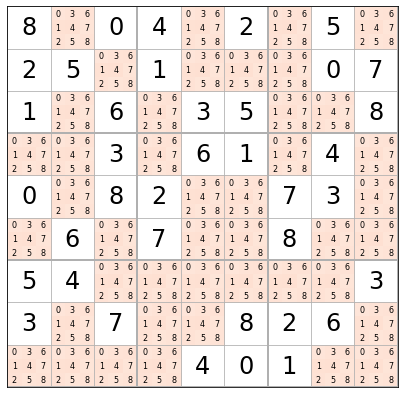

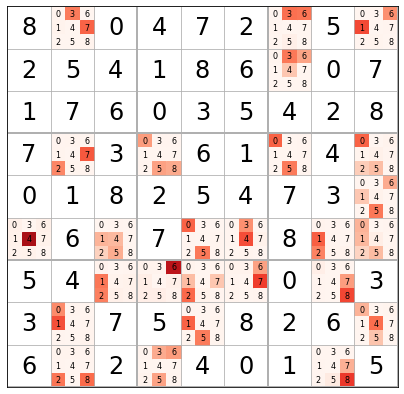

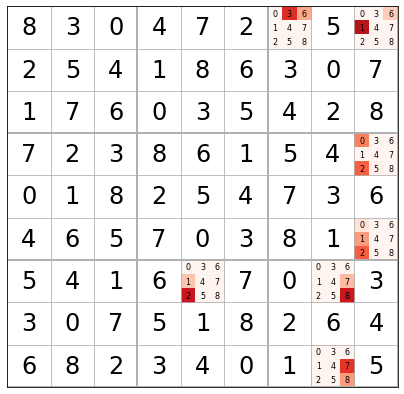

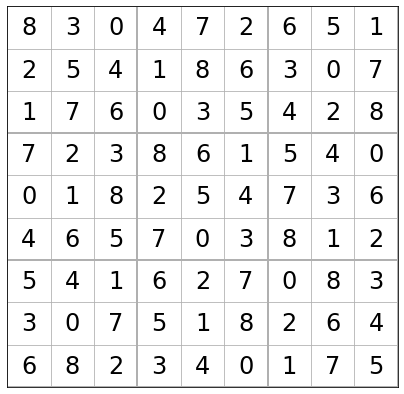

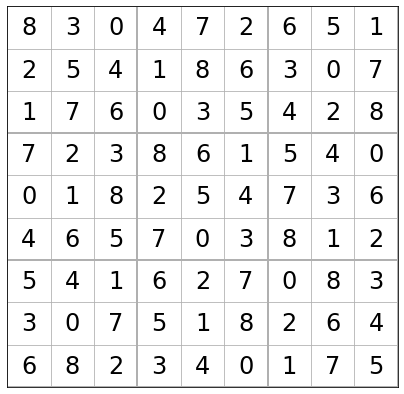

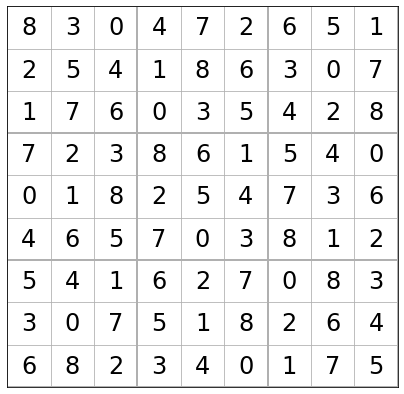

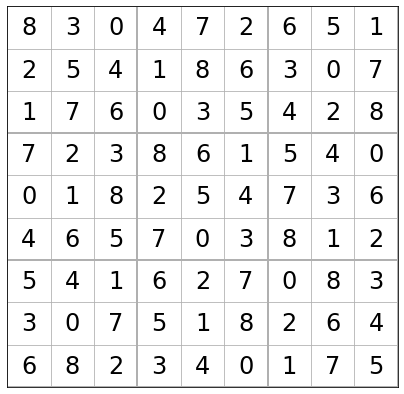

In [55]:
# Visualize graph iteration for one of the puzzles
ix = 0
for i in range(gnn.n_iters):
    tools.draw_sudoku(solution[i, 0], logits=True)

In [56]:
fraction_solved = fraction_of_solved_puzzles(gnn, testloader)
assert fraction_solved > .93, "Poor accuracy ({:.3f})".format(fraction_solved)
print('Success')

Success
